# Inception 

PyTorch version: 2.1.2+cu121
GPU available: True
Number of valid images: 1780
   label  count label_name
0      0    363  abundante
1      1    367       bajo
2      2    371   excesivo
3      3    364   moderado
4      4    315       nada


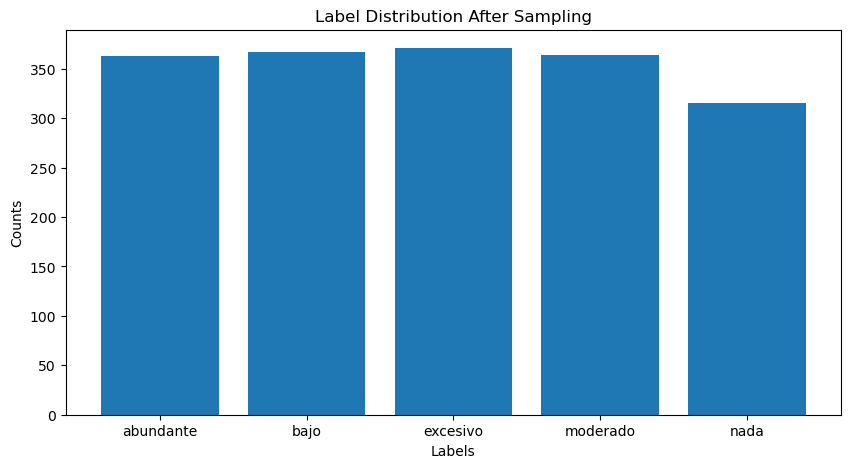

Epoch 1, Loss: 4.835674336978367, Train Accuracy: 21.292134831460675%, Val Accuracy: 14.125560538116591%
Epoch 2, Loss: 4.630943417549133, Train Accuracy: 23.651685393258425%, Val Accuracy: 27.80269058295964%
Epoch 3, Loss: 4.364858388900757, Train Accuracy: 29.55056179775281%, Val Accuracy: 38.789237668161434%
Epoch 4, Loss: 4.105339382375989, Train Accuracy: 30.56179775280899%, Val Accuracy: 44.84304932735426%
Epoch 5, Loss: 3.8047595620155334, Train Accuracy: 33.70786516853933%, Val Accuracy: 49.10313901345292%
Epoch 6, Loss: 3.4962293250220164, Train Accuracy: 37.97752808988764%, Val Accuracy: 49.775784753363226%
Epoch 7, Loss: 3.22683470589774, Train Accuracy: 42.359550561797754%, Val Accuracy: 49.10313901345292%
Epoch 8, Loss: 3.0150726522718156, Train Accuracy: 45.561797752808985%, Val Accuracy: 50.224215246636774%
Epoch 9, Loss: 2.9255101084709167, Train Accuracy: 45.168539325842694%, Val Accuracy: 49.55156950672646%
Epoch 10, Loss: 2.8072748354503085, Train Accuracy: 45.449438

KeyboardInterrupt: 

In [12]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

# Cargar el archivo CSV con las etiquetas
labels_df = pd.read_csv('labels/labels.csv')

# Codificar las etiquetas
label_encoder = LabelEncoder()
labels_df['label'] = label_encoder.fit_transform(labels_df['label'])

base_dir = 'images/'
labels_df['image_path'] = labels_df['image_name'].apply(lambda x: os.path.join(base_dir, x))

# Dividir en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Verificar si todas las rutas de imágenes son válidas
invalid_image_paths = []
for idx, row in train_df.iterrows():
    if not os.path.exists(row['image_path']):
        invalid_image_paths.append(idx)

# Eliminar filas con rutas de imágenes inválidas
if invalid_image_paths:
    print(f"Found {len(invalid_image_paths)} invalid image paths. Removing them.")
    train_df = train_df.drop(invalid_image_paths)

# Verificar nuevamente la longitud del DataFrame
print(f"Number of valid images: {len(train_df)}")

# Transformaciones de entrenamiento
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformaciones para clases minoritarias
minority_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformaciones de prueba
test_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Definición del dataset personalizado
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, minority_transform=None):
        self.df = dataframe
        self.transform = transform
        self.minority_transform = minority_transform
        self.minority_classes = [1, 2, 3]  # Supongamos que estas son las clases minoritarias

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_path']
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx]['label']
        label = torch.tensor(label, dtype=torch.long)
        
        if label in self.minority_classes and self.minority_transform:
            image = self.minority_transform(image)
        elif self.transform:
            image = self.transform(image)
            
        return image, label

# Crear datasets y dataloaders
train_dataset = CustomImageDataset(train_df, transform=train_transform, minority_transform=minority_transform)
test_dataset = CustomImageDataset(test_df, transform=test_transform)

# Calcular pesos de las clases
class_counts = labels_df['label'].value_counts().sort_index()
class_weights = 1. / class_counts
sample_weights = train_df['label'].apply(lambda x: class_weights[x])

# Crear sampler con los pesos
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verificar la distribución de las clases después de aplicar el sampler
label_counts_after_sampling = {label: 0 for label in range(len(label_encoder.classes_))}
for images, labels in train_loader:
    for label in labels:
        label_counts_after_sampling[label.item()] += 1

# Convertir el contador a un DataFrame para facilitar la visualización
label_distribution_df = pd.DataFrame(list(label_counts_after_sampling.items()), columns=['label', 'count'])

# Decodificar etiquetas
label_distribution_df['label_name'] = label_encoder.inverse_transform(label_distribution_df['label'])

# Imprimir la distribución
print(label_distribution_df)

# Graficar la distribución
plt.figure(figsize=(10, 5))
plt.bar(label_distribution_df['label_name'], label_distribution_df['count'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution After Sampling')
plt.show()

# Cargar el modelo InceptionV3 preentrenado
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
model.aux_logits = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(label_encoder.classes_))

# Configurar dispositivo, pérdida y optimizador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

train_losses = []
train_accuracy = []
val_accuracy = []

best_acc = 0.0

# Entrenamiento
for epoch in range(50):
    model.train()
    model.aux_logits = True
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Evaluación
    model.eval()
    model.aux_logits = False
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if outputs.dim() == 1:
                outputs = outputs.unsqueeze(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_accuracy.append(val_acc)

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {100 * correct / total}%, Val Accuracy: {val_acc}%')

    # Checkpointing
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')


# Métricas por época

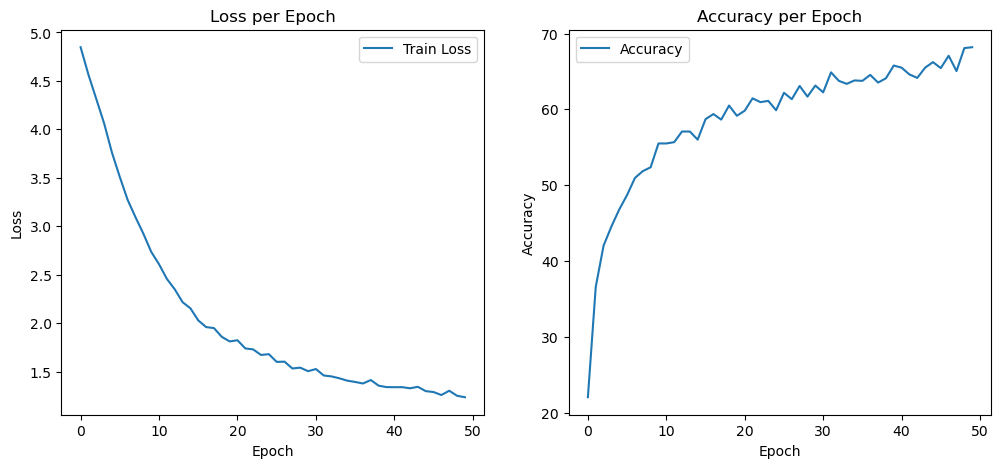

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Train Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(train_losses, train_accuracy)
